# Import libraries, read datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



In [2]:
df1 = pd.read_csv('/Users/Haleigh/Documents/MSDS/Adv_ML/Final_Project_CL_HS/datasets/bcsc_risk_factors_expanded1.csv')
df2 = pd.read_csv('/Users/Haleigh/Documents/MSDS/Adv_ML/Final_Project_CL_HS/datasets/bcsc_risk_factors_expanded2.csv')
df3 = pd.read_csv('/Users/Haleigh/Documents/MSDS/Adv_ML/Final_Project_CL_HS/datasets/bcsc_risk_factors_expanded3.csv')

In [3]:
#slight cleaning
df = pd.concat([df1, df2, df3])
df = df[df.ne(9).all(1)] #drop unknowns (9s)

# Preprocess

## Balance data

<Axes: xlabel='breast_cancer_history'>

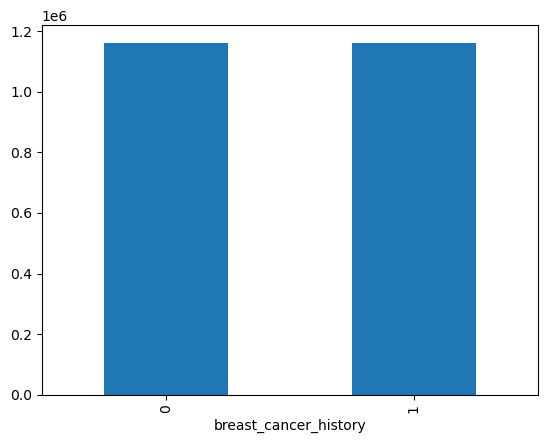

In [4]:
#since GMM doesn't have class_weight attribute, have to balance dataset first

# Identify the minority class
minority_class = df['breast_cancer_history'].value_counts().idxmin()
majority_class = df['breast_cancer_history'].value_counts().idxmax()

# Calculate how many samples to duplicate
samples_to_add = df['breast_cancer_history'].value_counts()[majority_class] - df['breast_cancer_history'].value_counts()[minority_class]

# Duplicate minority class samples
minority_samples = df[df['breast_cancer_history'] == minority_class].sample(n=samples_to_add, replace=True)

# Combine with the original dataset
balanced_df = pd.concat([df, minority_samples])

# Shuffle the dataset to mix the duplicated samples
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

#verify
balanced_df.breast_cancer_history.value_counts().plot(kind='bar')

## Scale, Encode

In [5]:
# split data into features (X) and labels (y)
#may need to drop biophx
X = balanced_df.drop('breast_cancer_history', axis=1)
y = balanced_df['breast_cancer_history']

In [6]:
#scale since one col is years, some cols go from 0-13, some from 0-2, etc
encoder = OneHotEncoder()
categorical_cols = ['year']

scaler = StandardScaler()
all_cols = balanced_df.columns.tolist()
numeric_cols = [col for col in all_cols if col not in categorical_cols]
numeric_cols.remove('breast_cancer_history')

#column transformer to preprocess corresponding columns
transformer = ColumnTransformer(
        [('categories', encoder, categorical_cols),
        ('numeric', scaler, numeric_cols)],
        remainder='drop', verbose_feature_names_out=False)


## Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Clustering methods

## PCA

Text(0.5, 1.0, 'Variance Explained by each Principle Component')

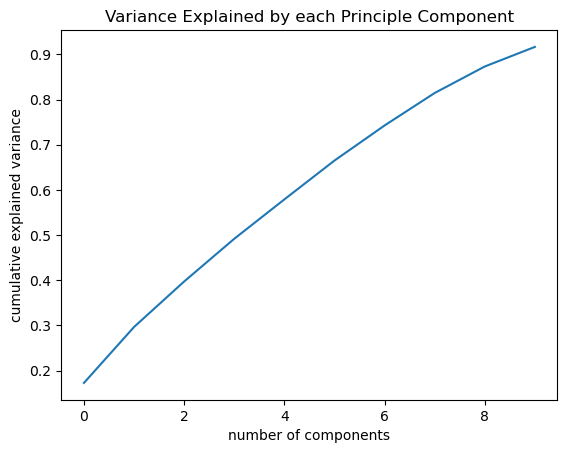

In [8]:
pca = Pipeline([('transform', transformer), #need to use transfomer since have both categorical and numeric data
                         ('pca', PCA(10))]) #first start with most of the features

pca.fit(X_train) 

pca['pca']

plt.plot(np.cumsum(pca['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


plt.title('Variance Explained by each Principle Component')

#need roughly 8 variables to explain 90% of variance

### Kmeans with PCA

In [30]:
kmeans_pca_pipeline = Pipeline([('transform', transformer),
                                ('pca', PCA(n_components=2))])

X_train_trans = kmeans_pca_pipeline.fit_transform(X_train)

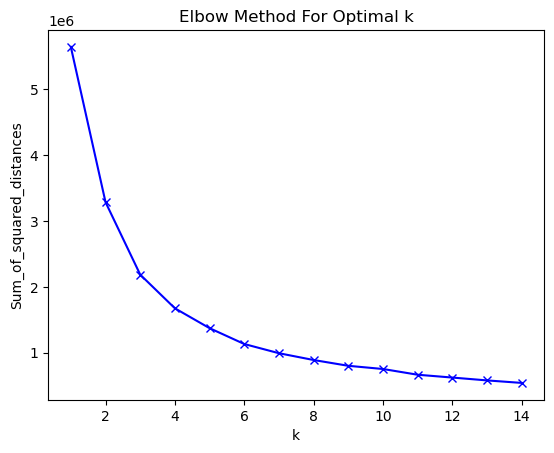

In [31]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train_trans)
    Sum_of_squared_distances.append(km.inertia_)
#Visualing the plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#not a very good elbow curve. can start with two since know that's how many groups there are

In [32]:
# Fit and plot the data for each k value
#for k in k_range:
kmeans = KMeans(n_clusters=2,
                init='k-means++', random_state=42)
kmeans_pca = kmeans.fit(X_train_trans) #do I need this?
y_kmeans = kmeans.fit_predict(X_train_trans)

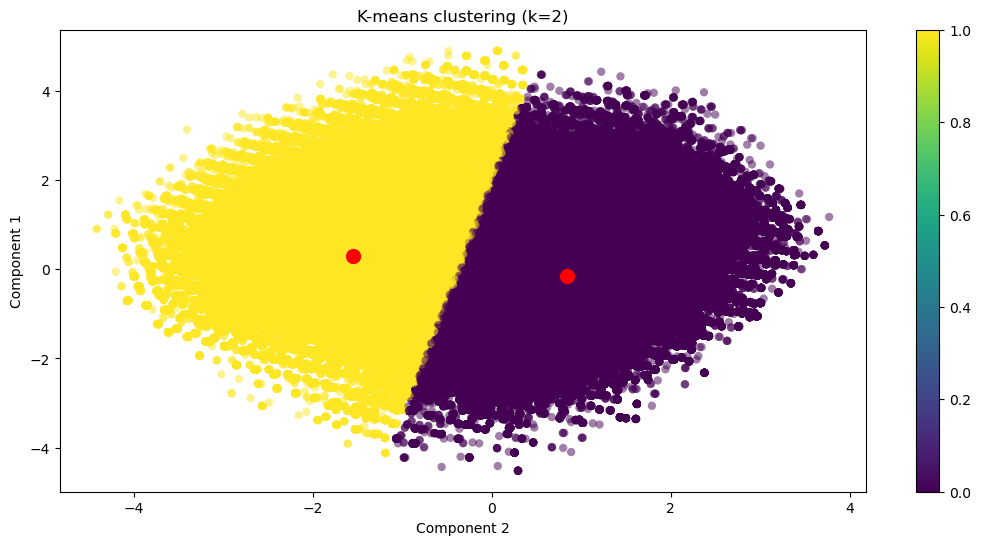

In [33]:
plt.figure(figsize=(13,6))
plt.scatter(X_train_trans[:, 0], X_train_trans[:, 1], 
            c=y_kmeans, edgecolor='none', 
            alpha=0.5, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0],\
            kmeans.cluster_centers_[:, 1], \
            s=100, c='red')
plt.title('K-means clustering (k=2)'.format(k))
plt.xlabel('Component 2')
plt.ylabel('Component 1')
plt.colorbar()
plt.show()

### Another way of doing KMeans with PCA

In [38]:
nclusters = 2 

In [37]:
# first define a plot fn

def plotData(df, groupby):
    # Make a scatterplot of the first two principal components of the data, colored by the groupby field.

    plt.figure(figsize=(7, 7))
    
    # Use seaborn scatterplot with hue for coloring by group
    sns.scatterplot(data=df, x='PC1', y='PC2', hue=groupby, palette='tab10', s=30)
    
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.title("Principal Components Analysis (PCA)")
    plt.grid(True)
    plt.legend(title=groupby)
    plt.show()

In [34]:
X_pca = pd.DataFrame(X_train_trans, columns=['PC1','PC2']) 
X_pca.sample(5)

,PC1,PC2
21215,-0.430627,-0.002194
1560589,1.090126,0.907043
1343951,1.516138,1.067740
1406471,-0.727491,-2.042832
1486838,1.045029,0.175593


In [35]:
df_plot = X_pca.copy()
df_plot['ClusterKmeans'] = y_kmeans
df_plot['breast_cancer_history'] = y
df_plot.sample(5)

,PC1,PC2,ClusterKmeans,breast_cancer_history
454661,-0.231594,1.716211,1,1
397780,-1.657999,0.205874,1,1
667891,-3.642154,-0.913724,1,1
1368457,-2.210750,-0.910682,1,1
264966,-2.328972,2.338995,1,1


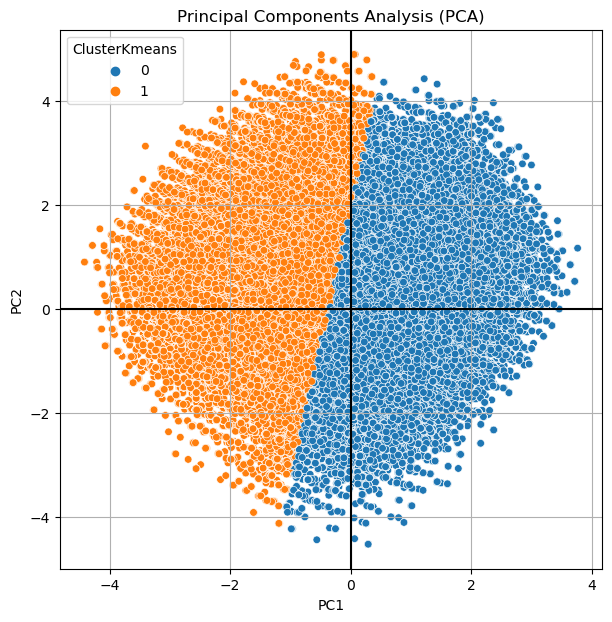

In [39]:
plotData(df_plot, 'ClusterKmeans') #confirms what we saw above

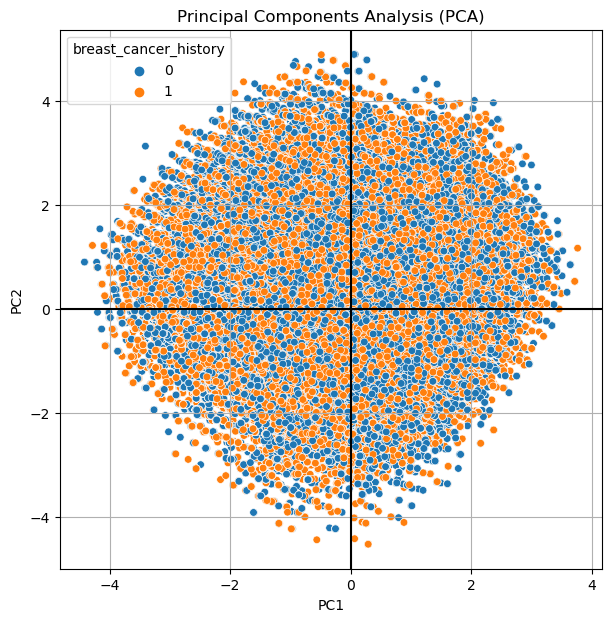

In [40]:
#actual labels
plotData(df_plot, 'breast_cancer_history')

### GMM with PCA

In [41]:
#gmm
nclusters=2 #since either 0 or 1
gmm = GaussianMixture(n_components=nclusters)
gmm.fit(X_train)

# predict the cluster for each data point
y_cluster_gmm = gmm.predict(X_train)
y_cluster_gmm


array([1, 1, 1, ..., 1, 1, 1])

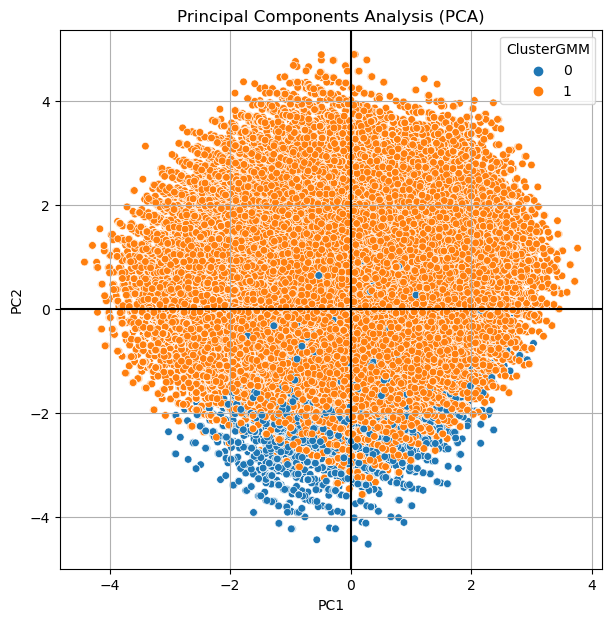

In [42]:
df_plot['ClusterGMM'] = y_cluster_gmm
plotData(df_plot, 'ClusterGMM')

## TSNE - SO SLOW!! stopped it at 4min

In [43]:
# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', max_iter=250)
X_tsne = tsne.fit_transform(X_train)

# Plot the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train)
plt.title("t-SNE")
plt.show()


# Ensemble - Supervised Learning

## Random forest, SVM, CatBoost, and Logisitic Regression

### Preprocess

In [9]:
#set up standard scaler
std_scaler = StandardScaler()
all_cols = df.columns.tolist()
all_cols.remove('breast_cancer_history')

In [5]:
#take random sample (to make ensemble run faster) and standard scale for the ensemble
df_sample = df.sample(frac=.2)
std_scaler.fit_transform(df_sample)

array([[-1.89722396,  0.50799851, -0.57627588, ..., -1.01030212,
        -0.55027855, -0.24836341],
       [ 0.30052752, -0.33668462, -0.57627588, ..., -1.01030212,
         1.81726145, -0.24836341],
       [-1.62250503, -0.75902618, -0.57627588, ...,  0.90397251,
        -0.55027855, -0.24836341],
       ...,
       [-1.34778609,  1.35268164,  0.2029946 , ...,  0.90397251,
        -0.55027855, -0.24836341],
       [-1.07306716,  0.08565695,  2.54080606, ..., -1.01030212,
        -0.55027855, -0.24836341],
       [-1.34778609,  0.50799851,  2.54080606, ..., -0.05316481,
        -0.55027855, -0.24836341]])

In [6]:
#split
X_sam = df_sample[all_cols]
y_sam = df_sample['breast_cancer_history'] 

X_train_sam, X_test_sam, y_train_sam, y_test_sam = train_test_split(X_sam, y_sam, random_state=0)

In [7]:
cv = RepeatedStratifiedKFold(n_repeats=3, random_state=1)

In [16]:
#don't run this unless you want to wait for 8 min lol


#set up ensemble with models that would work well classifying categorical, non-gaussian data
clf1 = LogisticRegression(class_weight='balanced') 
clf2 = RandomForestClassifier(random_state=1, class_weight='balanced') 
clf3 = CatBoostClassifier(auto_class_weights='Balanced')

#ensemble
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('boost', clf3)],
    voting='hard')

#find accuracies using cross validated scores
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'Cat Boost', 'Ensemble']):
    scores = cross_val_score(clf, X_train_sam, y_train_sam, scoring='accuracy', cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


#result: go with random forest
#Accuracy: 0.76 (+/- 0.00) [Logistic Regression]
#Accuracy: 0.90 (+/- 0.00) [Random Forest]
#ccuracy: 0.78 (+/- 0.00) [Cat Boost]
#Accuracy: 0.80 (+/- 0.00) [Ensemble]

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Accuracy: 0.76 (+/- 0.00) [Logistic Regression]
Accuracy: 0.90 (+/- 0.00) [Random Forest]
Learning rate set to 0.087012
0:	learn: 0.6540549	total: 69.5ms	remaining: 1m 9s
1:	learn: 0.6226295	total: 78ms	remaining: 38.9s
2:	learn: 0.5977802	total: 85.6ms	remaining: 28.5s
3:	learn: 0.5780818	total: 93ms	remaining: 23.2s
4:	learn: 0.5621232	total: 101ms	remaining: 20s
5:	learn: 0.5498330	total: 108ms	remaining: 17.9s
6:	learn: 0.5390760	total: 116ms	remaining: 16.5s
7:	learn: 0.5291027	total: 125ms	remaining: 15.4s
8:	learn: 0.5223963	total: 133ms	remaining: 14.6s
9:	learn: 0.5158083	total: 142ms	remaining: 14s
10:	learn: 0.5106702	total: 149ms	remaining: 13.4s
11:	learn: 0.5062955	total: 158ms	remaining: 13s
12:	learn: 0.5026322	total: 165ms	remaining: 12.5s
13:	learn: 0.4994448	total: 173ms	remaining: 12.2s
14:	learn: 0.4975575	total: 180ms	remaining: 11.8s
15:	learn: 0.4954604	total: 188ms	remaining: 11.5s
16:	learn: 0.4932799	total: 196ms	remaining: 11.3s
17:	learn: 0.4917080	total: 2

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6540549	total: 7.94ms	remaining: 7.94s
1:	learn: 0.6226295	total: 16.1ms	remaining: 8.06s
2:	learn: 0.5977802	total: 24ms	remaining: 7.96s
3:	learn: 0.5780818	total: 32.2ms	remaining: 8.02s
4:	learn: 0.5621232	total: 39.7ms	remaining: 7.91s
5:	learn: 0.5498330	total: 47.3ms	remaining: 7.83s
6:	learn: 0.5390760	total: 55.6ms	remaining: 7.89s
7:	learn: 0.5291027	total: 64.5ms	remaining: 7.99s
8:	learn: 0.5223963	total: 72.3ms	remaining: 7.96s
9:	learn: 0.5158083	total: 80.9ms	remaining: 8.01s
10:	learn: 0.5106702	total: 88.6ms	remaining: 7.97s
11:	learn: 0.5062955	total: 96.9ms	remaining: 7.97s
12:	learn: 0.5026322	total: 105ms	remaining: 7.94s
13:	learn: 0.4994448	total: 112ms	remaining: 7.9s
14:	learn: 0.4975575	total: 119ms	remaining: 7.81s
15:	learn: 0.4954604	total: 127ms	remaining: 7.78s
16:	learn: 0.4932799	total: 135ms	remaining: 7.79s
17:	learn: 0.4917080	total: 143ms	remaining: 7.81s
18:	learn: 0.4901379	total: 152ms	remaining: 7.83s
19

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6536905	total: 8.29ms	remaining: 8.28s
1:	learn: 0.6225160	total: 16.8ms	remaining: 8.38s
2:	learn: 0.5977897	total: 24.7ms	remaining: 8.21s
3:	learn: 0.5781619	total: 32.3ms	remaining: 8.04s
4:	learn: 0.5615840	total: 40.3ms	remaining: 8.02s
5:	learn: 0.5482370	total: 48.6ms	remaining: 8.05s
6:	learn: 0.5379556	total: 57.6ms	remaining: 8.18s
7:	learn: 0.5292253	total: 66.5ms	remaining: 8.24s
8:	learn: 0.5214074	total: 75ms	remaining: 8.25s
9:	learn: 0.5151725	total: 83.2ms	remaining: 8.24s
10:	learn: 0.5099152	total: 91.9ms	remaining: 8.26s
11:	learn: 0.5060087	total: 99.2ms	remaining: 8.16s
12:	learn: 0.5024363	total: 107ms	remaining: 8.14s
13:	learn: 0.4996404	total: 116ms	remaining: 8.16s
14:	learn: 0.4966181	total: 124ms	remaining: 8.16s
15:	learn: 0.4944442	total: 132ms	remaining: 8.11s
16:	learn: 0.4928758	total: 140ms	remaining: 8.07s
17:	learn: 0.4909871	total: 148ms	remaining: 8.09s
18:	learn: 0.4896552	total: 157ms	remaining: 8.08s
1

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6537153	total: 9.35ms	remaining: 9.34s
1:	learn: 0.6223554	total: 17.7ms	remaining: 8.85s
2:	learn: 0.5975709	total: 25.7ms	remaining: 8.53s
3:	learn: 0.5778990	total: 33.3ms	remaining: 8.29s
4:	learn: 0.5619647	total: 41.2ms	remaining: 8.19s
5:	learn: 0.5496136	total: 49.4ms	remaining: 8.18s
6:	learn: 0.5385603	total: 57.5ms	remaining: 8.15s
7:	learn: 0.5287563	total: 66.2ms	remaining: 8.21s
8:	learn: 0.5220923	total: 74.4ms	remaining: 8.2s
9:	learn: 0.5160758	total: 82.9ms	remaining: 8.2s
10:	learn: 0.5105124	total: 91.6ms	remaining: 8.24s
11:	learn: 0.5059970	total: 99.9ms	remaining: 8.23s
12:	learn: 0.5021483	total: 108ms	remaining: 8.19s
13:	learn: 0.4991562	total: 116ms	remaining: 8.17s
14:	learn: 0.4968518	total: 125ms	remaining: 8.18s
15:	learn: 0.4947511	total: 133ms	remaining: 8.17s
16:	learn: 0.4927795	total: 142ms	remaining: 8.19s
17:	learn: 0.4911540	total: 150ms	remaining: 8.2s
18:	learn: 0.4897277	total: 159ms	remaining: 8.2s
19:

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6542473	total: 8.11ms	remaining: 8.1s
1:	learn: 0.6229497	total: 16.5ms	remaining: 8.24s
2:	learn: 0.5981780	total: 24.3ms	remaining: 8.08s
3:	learn: 0.5784733	total: 32.2ms	remaining: 8.02s
4:	learn: 0.5625121	total: 40.1ms	remaining: 7.97s
5:	learn: 0.5501621	total: 48.4ms	remaining: 8.01s
6:	learn: 0.5391435	total: 56.3ms	remaining: 7.99s
7:	learn: 0.5294130	total: 65.2ms	remaining: 8.08s
8:	learn: 0.5226764	total: 73.3ms	remaining: 8.07s
9:	learn: 0.5166327	total: 81.7ms	remaining: 8.09s
10:	learn: 0.5112248	total: 90.3ms	remaining: 8.12s
11:	learn: 0.5067413	total: 98.9ms	remaining: 8.14s
12:	learn: 0.5028965	total: 107ms	remaining: 8.14s
13:	learn: 0.5000636	total: 116ms	remaining: 8.15s
14:	learn: 0.4977907	total: 124ms	remaining: 8.15s
15:	learn: 0.4955921	total: 133ms	remaining: 8.15s
16:	learn: 0.4935814	total: 141ms	remaining: 8.16s
17:	learn: 0.4917896	total: 149ms	remaining: 8.11s
18:	learn: 0.4902670	total: 157ms	remaining: 8.13s


/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6548486	total: 7.87ms	remaining: 7.86s
1:	learn: 0.6243664	total: 15.3ms	remaining: 7.64s
2:	learn: 0.5997902	total: 22.9ms	remaining: 7.6s
3:	learn: 0.5817441	total: 29.5ms	remaining: 7.34s
4:	learn: 0.5643856	total: 37.8ms	remaining: 7.52s
5:	learn: 0.5506052	total: 45.6ms	remaining: 7.55s
6:	learn: 0.5395606	total: 54.4ms	remaining: 7.71s
7:	learn: 0.5318074	total: 62.9ms	remaining: 7.8s
8:	learn: 0.5231887	total: 71.5ms	remaining: 7.87s
9:	learn: 0.5165751	total: 79.4ms	remaining: 7.86s
10:	learn: 0.5112472	total: 87.2ms	remaining: 7.84s
11:	learn: 0.5068022	total: 95ms	remaining: 7.83s
12:	learn: 0.5032347	total: 104ms	remaining: 7.86s
13:	learn: 0.5001864	total: 112ms	remaining: 7.87s
14:	learn: 0.4971652	total: 120ms	remaining: 7.89s
15:	learn: 0.4950194	total: 129ms	remaining: 7.91s
16:	learn: 0.4930323	total: 137ms	remaining: 7.92s
17:	learn: 0.4913217	total: 146ms	remaining: 7.95s
18:	learn: 0.4898475	total: 154ms	remaining: 7.97s
19:

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6538822	total: 8.42ms	remaining: 8.42s
1:	learn: 0.6224184	total: 16.8ms	remaining: 8.4s
2:	learn: 0.5976203	total: 24.7ms	remaining: 8.22s
3:	learn: 0.5779045	total: 32.3ms	remaining: 8.05s
4:	learn: 0.5620196	total: 39.8ms	remaining: 7.92s
5:	learn: 0.5496192	total: 47.4ms	remaining: 7.85s
6:	learn: 0.5395541	total: 55.6ms	remaining: 7.89s
7:	learn: 0.5295607	total: 64.8ms	remaining: 8.04s
8:	learn: 0.5227185	total: 72.8ms	remaining: 8.01s
9:	learn: 0.5159965	total: 81.3ms	remaining: 8.05s
10:	learn: 0.5106723	total: 88.8ms	remaining: 7.99s
11:	learn: 0.5061818	total: 97ms	remaining: 7.99s
12:	learn: 0.5024264	total: 105ms	remaining: 7.94s
13:	learn: 0.4992168	total: 113ms	remaining: 7.95s
14:	learn: 0.4973597	total: 120ms	remaining: 7.87s
15:	learn: 0.4948637	total: 130ms	remaining: 8.02s
16:	learn: 0.4929090	total: 141ms	remaining: 8.18s
17:	learn: 0.4909872	total: 151ms	remaining: 8.25s
18:	learn: 0.4896427	total: 160ms	remaining: 8.28s
19

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6540690	total: 9.78ms	remaining: 9.77s
1:	learn: 0.6230816	total: 18.4ms	remaining: 9.16s
2:	learn: 0.5986186	total: 26.2ms	remaining: 8.72s
3:	learn: 0.5790630	total: 34.3ms	remaining: 8.53s
4:	learn: 0.5627033	total: 42.2ms	remaining: 8.4s
5:	learn: 0.5496611	total: 50.3ms	remaining: 8.32s
6:	learn: 0.5391301	total: 58.7ms	remaining: 8.33s
7:	learn: 0.5304860	total: 67.9ms	remaining: 8.42s
8:	learn: 0.5228358	total: 76.7ms	remaining: 8.44s
9:	learn: 0.5168129	total: 84.6ms	remaining: 8.37s
10:	learn: 0.5117179	total: 93.1ms	remaining: 8.37s
11:	learn: 0.5076737	total: 101ms	remaining: 8.3s
12:	learn: 0.5037113	total: 110ms	remaining: 8.32s
13:	learn: 0.5009888	total: 118ms	remaining: 8.28s
14:	learn: 0.4986551	total: 125ms	remaining: 8.21s
15:	learn: 0.4961744	total: 133ms	remaining: 8.2s
16:	learn: 0.4948015	total: 140ms	remaining: 8.11s
17:	learn: 0.4927076	total: 149ms	remaining: 8.11s
18:	learn: 0.4913230	total: 157ms	remaining: 8.13s
19:

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6546090	total: 9.65ms	remaining: 9.64s
1:	learn: 0.6240687	total: 20.7ms	remaining: 10.3s
2:	learn: 0.5991351	total: 30.8ms	remaining: 10.2s
3:	learn: 0.5794849	total: 38.5ms	remaining: 9.59s
4:	learn: 0.5624266	total: 47.6ms	remaining: 9.48s
5:	learn: 0.5491543	total: 56.5ms	remaining: 9.36s
6:	learn: 0.5388332	total: 64.7ms	remaining: 9.18s
7:	learn: 0.5307094	total: 73.6ms	remaining: 9.13s
8:	learn: 0.5227264	total: 82.3ms	remaining: 9.06s
9:	learn: 0.5159958	total: 91.2ms	remaining: 9.03s
10:	learn: 0.5103126	total: 100ms	remaining: 9.01s
11:	learn: 0.5063005	total: 108ms	remaining: 8.87s
12:	learn: 0.5026326	total: 116ms	remaining: 8.79s
13:	learn: 0.4997355	total: 125ms	remaining: 8.79s
14:	learn: 0.4966905	total: 134ms	remaining: 8.77s
15:	learn: 0.4946210	total: 142ms	remaining: 8.73s
16:	learn: 0.4930902	total: 151ms	remaining: 8.72s
17:	learn: 0.4916378	total: 158ms	remaining: 8.63s
18:	learn: 0.4902961	total: 166ms	remaining: 8.6s
19

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6536491	total: 9.29ms	remaining: 9.29s
1:	learn: 0.6222116	total: 17.9ms	remaining: 8.91s
2:	learn: 0.5972738	total: 25.9ms	remaining: 8.61s
3:	learn: 0.5774783	total: 33.7ms	remaining: 8.38s
4:	learn: 0.5613393	total: 41.7ms	remaining: 8.29s
5:	learn: 0.5489588	total: 49.4ms	remaining: 8.19s
6:	learn: 0.5389797	total: 58ms	remaining: 8.23s
7:	learn: 0.5289723	total: 66.8ms	remaining: 8.29s
8:	learn: 0.5221840	total: 75.1ms	remaining: 8.27s
9:	learn: 0.5159552	total: 83.4ms	remaining: 8.26s
10:	learn: 0.5102557	total: 92ms	remaining: 8.27s
11:	learn: 0.5056129	total: 99.7ms	remaining: 8.21s
12:	learn: 0.5017898	total: 107ms	remaining: 8.15s
13:	learn: 0.4986171	total: 116ms	remaining: 8.13s
14:	learn: 0.4958709	total: 124ms	remaining: 8.13s
15:	learn: 0.4940655	total: 131ms	remaining: 8.06s
16:	learn: 0.4919541	total: 139ms	remaining: 8.06s
17:	learn: 0.4903654	total: 148ms	remaining: 8.07s
18:	learn: 0.4887606	total: 156ms	remaining: 8.07s
19:

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6535227	total: 8.52ms	remaining: 8.52s
1:	learn: 0.6223534	total: 17.6ms	remaining: 8.79s
2:	learn: 0.5976012	total: 25.9ms	remaining: 8.59s
3:	learn: 0.5780056	total: 33.7ms	remaining: 8.39s
4:	learn: 0.5620361	total: 41.2ms	remaining: 8.2s
5:	learn: 0.5498148	total: 49.2ms	remaining: 8.15s
6:	learn: 0.5400919	total: 57.7ms	remaining: 8.19s
7:	learn: 0.5301024	total: 66.1ms	remaining: 8.2s
8:	learn: 0.5224882	total: 74.4ms	remaining: 8.19s
9:	learn: 0.5158798	total: 82.9ms	remaining: 8.21s
10:	learn: 0.5112833	total: 90ms	remaining: 8.1s
11:	learn: 0.5072783	total: 97.3ms	remaining: 8.01s
12:	learn: 0.5035458	total: 106ms	remaining: 8.03s
13:	learn: 0.5003563	total: 114ms	remaining: 8.05s
14:	learn: 0.4973351	total: 123ms	remaining: 8.08s
15:	learn: 0.4949689	total: 131ms	remaining: 8.08s
16:	learn: 0.4937425	total: 139ms	remaining: 8.01s
17:	learn: 0.4919523	total: 147ms	remaining: 8.03s
18:	learn: 0.4906472	total: 155ms	remaining: 8.01s
19:	

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6541790	total: 8.99ms	remaining: 8.98s
1:	learn: 0.6223496	total: 17.8ms	remaining: 8.86s
2:	learn: 0.5982630	total: 25.8ms	remaining: 8.57s
3:	learn: 0.5782701	total: 33.4ms	remaining: 8.32s
4:	learn: 0.5622242	total: 41ms	remaining: 8.16s
5:	learn: 0.5497965	total: 49ms	remaining: 8.13s
6:	learn: 0.5387489	total: 57.8ms	remaining: 8.2s
7:	learn: 0.5294115	total: 65.8ms	remaining: 8.16s
8:	learn: 0.5212242	total: 74.2ms	remaining: 8.17s
9:	learn: 0.5143967	total: 82.7ms	remaining: 8.19s
10:	learn: 0.5091876	total: 91.3ms	remaining: 8.21s
11:	learn: 0.5044772	total: 99.9ms	remaining: 8.22s
12:	learn: 0.5006510	total: 108ms	remaining: 8.21s
13:	learn: 0.4976357	total: 116ms	remaining: 8.18s
14:	learn: 0.4950113	total: 124ms	remaining: 8.14s
15:	learn: 0.4926250	total: 132ms	remaining: 8.13s
16:	learn: 0.4907070	total: 141ms	remaining: 8.13s
17:	learn: 0.4892175	total: 149ms	remaining: 8.13s
18:	learn: 0.4877782	total: 158ms	remaining: 8.13s
19:	

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6541715	total: 8.63ms	remaining: 8.62s
1:	learn: 0.6232999	total: 17.5ms	remaining: 8.72s
2:	learn: 0.5987937	total: 25.2ms	remaining: 8.37s
3:	learn: 0.5793319	total: 32.7ms	remaining: 8.15s
4:	learn: 0.5628855	total: 41ms	remaining: 8.16s
5:	learn: 0.5501352	total: 49ms	remaining: 8.12s
6:	learn: 0.5393426	total: 57.7ms	remaining: 8.18s
7:	learn: 0.5301695	total: 66.2ms	remaining: 8.21s
8:	learn: 0.5230328	total: 74.6ms	remaining: 8.21s
9:	learn: 0.5174625	total: 83ms	remaining: 8.22s
10:	learn: 0.5118832	total: 91.4ms	remaining: 8.21s
11:	learn: 0.5080022	total: 98.9ms	remaining: 8.14s
12:	learn: 0.5044344	total: 107ms	remaining: 8.16s
13:	learn: 0.5020387	total: 116ms	remaining: 8.15s
14:	learn: 0.4991280	total: 124ms	remaining: 8.15s
15:	learn: 0.4971127	total: 132ms	remaining: 8.1s
16:	learn: 0.4953222	total: 140ms	remaining: 8.11s
17:	learn: 0.4938206	total: 148ms	remaining: 8.06s
18:	learn: 0.4925001	total: 155ms	remaining: 8.01s
19:	le

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6544858	total: 9.68ms	remaining: 9.67s
1:	learn: 0.6233197	total: 18.3ms	remaining: 9.12s
2:	learn: 0.5987481	total: 25.9ms	remaining: 8.6s
3:	learn: 0.5800800	total: 33.5ms	remaining: 8.33s
4:	learn: 0.5628178	total: 42.2ms	remaining: 8.39s
5:	learn: 0.5499863	total: 50.6ms	remaining: 8.38s
6:	learn: 0.5388903	total: 58.6ms	remaining: 8.31s
7:	learn: 0.5295834	total: 67.1ms	remaining: 8.32s
8:	learn: 0.5228766	total: 75.3ms	remaining: 8.29s
9:	learn: 0.5166403	total: 84.2ms	remaining: 8.33s
10:	learn: 0.5116843	total: 92.7ms	remaining: 8.34s
11:	learn: 0.5078372	total: 100ms	remaining: 8.27s
12:	learn: 0.5040736	total: 109ms	remaining: 8.28s
13:	learn: 0.5009941	total: 117ms	remaining: 8.23s
14:	learn: 0.4989195	total: 123ms	remaining: 8.11s
15:	learn: 0.4964934	total: 131ms	remaining: 8.06s
16:	learn: 0.4945985	total: 139ms	remaining: 8.02s
17:	learn: 0.4933314	total: 147ms	remaining: 8.04s
18:	learn: 0.4916882	total: 156ms	remaining: 8.04s
1

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6543859	total: 8.67ms	remaining: 8.66s
1:	learn: 0.6231111	total: 17.4ms	remaining: 8.69s
2:	learn: 0.5983121	total: 25.3ms	remaining: 8.4s
3:	learn: 0.5786601	total: 32.5ms	remaining: 8.09s
4:	learn: 0.5617479	total: 41ms	remaining: 8.16s
5:	learn: 0.5489398	total: 48.9ms	remaining: 8.1s
6:	learn: 0.5396241	total: 55.9ms	remaining: 7.93s
7:	learn: 0.5305512	total: 64.1ms	remaining: 7.95s
8:	learn: 0.5239919	total: 71.6ms	remaining: 7.88s
9:	learn: 0.5184207	total: 80.1ms	remaining: 7.92s
10:	learn: 0.5124256	total: 88.5ms	remaining: 7.96s
11:	learn: 0.5077891	total: 96.7ms	remaining: 7.96s
12:	learn: 0.5041282	total: 105ms	remaining: 7.98s
13:	learn: 0.5008438	total: 114ms	remaining: 8.03s
14:	learn: 0.4982944	total: 122ms	remaining: 8.03s
15:	learn: 0.4967513	total: 130ms	remaining: 7.98s
16:	learn: 0.4946401	total: 138ms	remaining: 7.99s
17:	learn: 0.4925716	total: 146ms	remaining: 7.99s
18:	learn: 0.4910640	total: 155ms	remaining: 8s
19:	le

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.087012
0:	learn: 0.6542598	total: 7.93ms	remaining: 7.93s
1:	learn: 0.6233524	total: 16.4ms	remaining: 8.18s
2:	learn: 0.5981296	total: 24.9ms	remaining: 8.29s
3:	learn: 0.5783099	total: 32.6ms	remaining: 8.11s
4:	learn: 0.5614740	total: 40.6ms	remaining: 8.07s
5:	learn: 0.5480023	total: 48.8ms	remaining: 8.09s
6:	learn: 0.5373550	total: 56.7ms	remaining: 8.04s
7:	learn: 0.5286676	total: 65.3ms	remaining: 8.09s
8:	learn: 0.5207684	total: 73.7ms	remaining: 8.12s
9:	learn: 0.5141485	total: 82.2ms	remaining: 8.13s
10:	learn: 0.5084882	total: 90.8ms	remaining: 8.16s
11:	learn: 0.5044663	total: 98.3ms	remaining: 8.09s
12:	learn: 0.5008753	total: 107ms	remaining: 8.11s
13:	learn: 0.4980312	total: 115ms	remaining: 8.1s
14:	learn: 0.4949886	total: 124ms	remaining: 8.13s
15:	learn: 0.4930026	total: 132ms	remaining: 8.12s
16:	learn: 0.4909073	total: 140ms	remaining: 8.12s
17:	learn: 0.4894000	total: 149ms	remaining: 8.12s
18:	learn: 0.4880072	total: 157ms	remaining: 8.09s


## Move forward with random forest

### Hyperparameterize

In [26]:
#set model, find names of parameters
rf =  RandomForestClassifier(random_state=1, class_weight='balanced')
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [27]:
# not random search since have to have some specific ones for criterion
parameters = {
    'max_depth': (10,100,200),
    'n_estimators': (10,100,200),
    'criterion': ('gini', 'log_loss', 'entropy')
}

#apply to model
grid_search = GridSearchCV(rf, parameters, cv=3, n_jobs=-1, verbose=1)

#fit
grid_search.fit(X_train_sam, y_train_sam) #use just sample data d/t speed

#find best score and parameter
grid_search.best_estimator_.get_params() 

# {'bootstrap': True, 
# 'ccp_alpha': 0.0,
#  'class_weight': 'balanced',
#  'criterion': 'gini',
#  'max_depth': 100,
#  'max_features': 'sqrt',
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'min_weight_fraction_leaf': 0.0,
#  'monotonic_cst': None,
#  'n_estimators': 10,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': 1,
#  'verbose': 0,
#  'warm_start': False}

grid_search.best_score_  #0.9071816997029319


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/Haleigh/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 100,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

### Split whole ds

In [29]:
#split - don't use!!

# X = df[all_cols]
# y = df['breast_cancer_history'] 

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [10]:
#got bad confusion matrix when just used class_weights='balanced' so will try this method instead

def split_and_balance(data):
    X_train, X_test, y_train, y_test = train_test_split(data, data['breast_cancer_history'], stratify = data['breast_cancer_history'], random_state=42) 
    X_train_ca = X_train[X_train['breast_cancer_history'] == 1]
    X_train_no_ca = X_train[X_train['breast_cancer_history'] == 0]
    num_matches = X_train_ca['breast_cancer_history'].count()
    X_train_no_ca = X_train_no_ca.sample(n=num_matches)

    X_train_no_ca.shape

    X_train_final = pd.concat([X_train_ca, X_train_no_ca])

    y_train_final = X_train_final['breast_cancer_history']
    X_train_final = X_train_final.loc[:, X_train_final.columns != 'breast_cancer_history']

    X_test = X_test.loc[:, X_test.columns != 'breast_cancer_history']

    return X_train_final, y_train_final, X_test, y_test

In [11]:
X_train_final, y_train_final, X_test, y_test = split_and_balance(df)

### Set up pipeline

In [14]:
#set up pipeline
classification_pipeline = Pipeline([('std_scale', std_scaler),
                                    ('pca', PCA(8)),
                                    ('RF', RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=100, min_impurity_decrease= 0.0, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 10, random_state= 1, verbose=0))])

classification_pipeline.fit(X_train_final, y_train_final)

Pipeline(steps=[('std_scale', StandardScaler()), ('pca', PCA(n_components=8)),
                ('RF',
                 RandomForestClassifier(class_weight='balanced', max_depth=100,
                                        n_estimators=10, random_state=1))])

### Cross validate

In [15]:
#cross validate
scores = cross_val_score(classification_pipeline, X_train_final, y_train_final, cv=5)
print(scores.mean(), '\t', scores.std())

# 0.7348503312579394 	 0.001088741014065322


0.7348503312579394 	 0.001088741014065322


### Test data

In [16]:
#fit and predict
classification_pipeline.fit(X_train_final, y_train_final)
classification_pipeline.predict(X_test)

array([1, 0, 0, ..., 0, 1, 1])

In [17]:
#find accuracy
y_pred = classification_pipeline.predict(X_test)
sum(y_pred == y_test) / len(y_test)
#0.7332158916162186

0.7332158916162186

### Confusion matrix

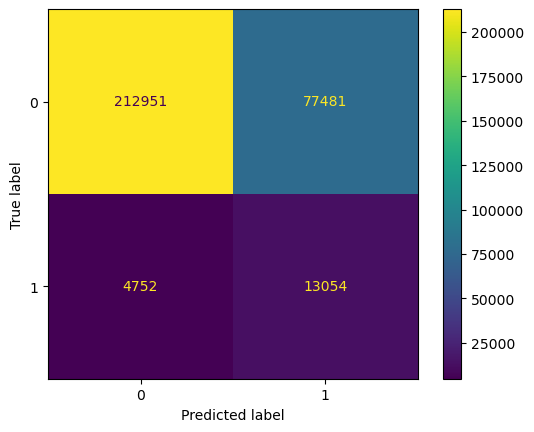

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels=classification_pipeline.classes_)

disp.plot()

### Add column of probability

In [21]:
df_x.columns

Index(['year', 'age_group_5_years', 'race_eth', 'first_degree_hx',
       'age_menarche', 'age_first_birth', 'BIRADS_breast_density',
       'current_hrt', 'menopaus', 'bmi_group', 'biophx',
       'breast_cancer_probability'],
      dtype='object')

In [19]:
#drop true result
df_x = df.drop('breast_cancer_history', axis=1)

#predict probability of having breast ca
probabilities = classification_pipeline.predict_proba(df_x)[:, 1]  # Assuming breast cancer is the positive class

# Add the probabilities to the DataFrame
df_x['breast_cancer_probability'] = probabilities

#merge probabilities with actual results
df_total = df_x.copy()
df_total['breast_cancer_history'] = df['breast_cancer_history']

In [20]:
# Display the updated DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_total.head(20)

,year,age_group_5_years,race_eth,first_degree_hx,age_menarche,age_first_birth,BIRADS_breast_density,current_hrt,menopaus,bmi_group,biophx,breast_cancer_probability,breast_cancer_history
15100,2013,7,1,1,0,0,1,0,2,3,0,0.300000,0
15101,2013,7,1,1,0,0,1,0,2,3,0,0.300000,0
15102,2013,7,1,1,0,0,1,0,2,4,1,1.000000,0
15103,2013,7,1,1,0,0,1,0,3,2,1,0.750000,0
15104,2013,7,1,1,0,0,1,0,3,4,0,0.050000,0
15105,2013,7,1,1,0,0,2,0,1,3,0,0.333333,0
15106,2013,7,1,1,0,0,2,0,1,4,1,1.000000,1
15107,2013,7,1,1,0,0,2,0,2,1,0,0.200000,0
15108,2013,7,1,1,0,0,2,0,2,1,1,0.900000,0
15109,2013,7,1,1,0,0,2,0,2,1,1,0.900000,0


# Neural Network - Unsupervised Learning (Ignore, use Christy's instead!)

## Preprocess

In [34]:
#label encode year
X_year = X['year']
X_year = pd.DataFrame(X_year)
label_encode = LabelEncoder()
X_year_encode = label_encode.fit_transform(X_year)

/Users/Haleigh/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
#standard scale the rest
X_rest = X.drop('year', axis=1)
scaler2 = StandardScaler()
X_rest_scale = scaler2.fit_transform(X_rest)

In [17]:
#join all cols back
X_year_encode = pd.DataFrame(X_year_encode, columns=X_year.columns)
y = pd.DataFrame(y)
X_rest_scale = pd.DataFrame(X_rest_scale, columns=X_rest.columns)

df_scale = pd.concat([X_rest_scale, X_year_encode, y], axis=1)


,year
0,2010
1,2007
2,2017
3,2007
4,2016
...,...
2323449,2006
2323450,2017
2323451,2015
2323452,2012


In [37]:
#split
train_data, test_data = train_test_split(df_scale, test_size=0.2, random_state=42)

### Make NN

In [53]:
# Define a custom PyTorch dataset
class Ca_Dataset(Dataset):
    def __init__(self, data):
        self.X = data[[col for col in all_cols if col != "breast_cancer_history"]].values  # Exclude target column
        self.y = data["breast_cancer_history"].values
        self.n_samples = len(data)

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.int64)

    def __len__(self):
        return self.n_samples

In [54]:
# Create PyTorch datasets and dataloaders
train_dataset = Ca_Dataset(train_data)
test_dataset = Ca_Dataset(test_data)

train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

In [55]:
# Define a simple neural network with one hidden layer
class Ca_NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Ca_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [56]:
# Initialize the model, loss function, and optimizer
input_size = 11 #number of features
hidden_size = 64
num_classes = 2
learning_rate = 0.001

model = Ca_NN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 0.4825
Epoch 2/5, Loss: 0.4800
Epoch 3/5, Loss: 0.4792
Epoch 4/5, Loss: 0.4787
Epoch 5/5, Loss: 0.4783


In [58]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy:.2%}")

#Accuracy on test set: 77.97%

Accuracy on test set: 77.97%


### Need to redo with balanced class weights